In [ ]:
#import the dataset from the drive
!pip install -U -q PyDrive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':'1E36cSGIaAkRyhmCDsBEjK8Y6SxzEmQxc'}) 
downloaded.GetContentFile('train-new.csv')  
data=pd.read_csv('train-new.csv')
data.head()

,dvcat,weight,dead,airbag,seatbelt,frontal,sex,ageOFocc,yearacc,yearVeh,abcat,occRole,deploy,caseid,injSeverity
0,55+,53.342,dead,airbag,belted,1,f,48,2002,1997,deploy,driver,1,45:150:1,3
1,25-39,154.960,alive,none,none,1,m,26,2001,1968,unavail,driver,0,76:40:1,3
2,55+,38.994,alive,none,none,1,f,51,2002,1994,unavail,driver,0,11:184:1,3
3,25-39,168.568,alive,airbag,belted,1,m,27,1998,1996,deploy,pass,1,9:17:1,3
4,10-24,27.751,alive,airbag,belted,0,m,26,2002,1997,nodeploy,pass,0,2:2:2,0


In [ ]:
print("the rate of dead is",len(data[data["dead"]=="dead"])/data.shape[0])

the rate of dead is 0.04423569598633646


In [ ]:
data.head()

,dvcat,weight,dead,airbag,seatbelt,frontal,sex,ageOFocc,yearacc,yearVeh,abcat,occRole,deploy,caseid,injSeverity
0,55+,53.342,dead,airbag,belted,1,f,48,2002,1997,deploy,driver,1,45:150:1,3
1,25-39,154.960,alive,none,none,1,m,26,2001,1968,unavail,driver,0,76:40:1,3
2,55+,38.994,alive,none,none,1,f,51,2002,1994,unavail,driver,0,11:184:1,3
3,25-39,168.568,alive,airbag,belted,1,m,27,1998,1996,deploy,pass,1,9:17:1,3
4,10-24,27.751,alive,airbag,belted,0,m,26,2002,1997,nodeploy,pass,0,2:2:2,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17565 entries, 0 to 17564
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dvcat        17565 non-null  object 
 1   weight       17565 non-null  float64
 2   dead         17565 non-null  object 
 3   airbag       17565 non-null  object 
 4   seatbelt     17565 non-null  object 
 5   frontal      17565 non-null  int64  
 6   sex          17565 non-null  object 
 7   ageOFocc     17565 non-null  int64  
 8   yearacc      17565 non-null  int64  
 9   yearVeh      17565 non-null  int64  
 10  abcat        17565 non-null  object 
 11  occRole      17565 non-null  object 
 12  deploy       17565 non-null  int64  
 13  caseid       17565 non-null  object 
 14  injSeverity  17565 non-null  int64  
dtypes: float64(1), int64(6), object(8)
memory usage: 2.0+ MB


In [ ]:
data.nunique()

dvcat             5
weight         8406
dead              2
airbag            2
seatbelt          2
frontal           2
sex               2
ageOFocc         82
yearacc           6
yearVeh          44
abcat             3
occRole           2
deploy            2
caseid         8236
injSeverity       7
dtype: int64

In [ ]:
data.isna().sum()

dvcat          0
weight         0
dead           0
airbag         0
seatbelt       0
frontal        0
sex            0
ageOFocc       0
yearacc        0
yearVeh        0
abcat          0
occRole        0
deploy         0
caseid         0
injSeverity    0
dtype: int64

there is no nan value

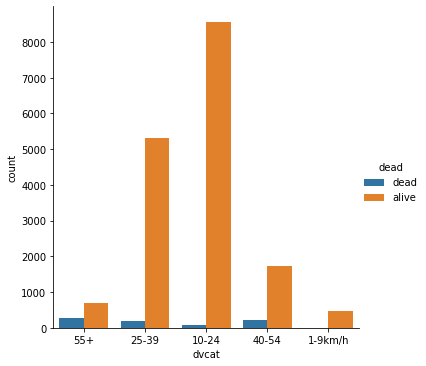

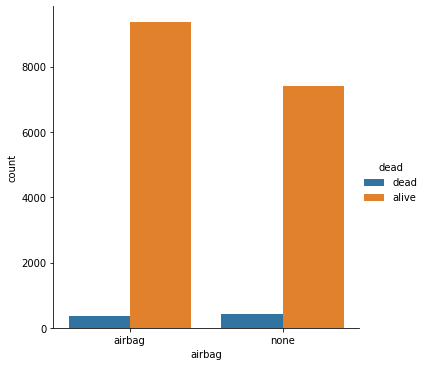

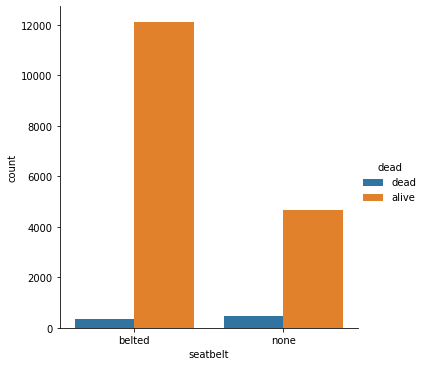

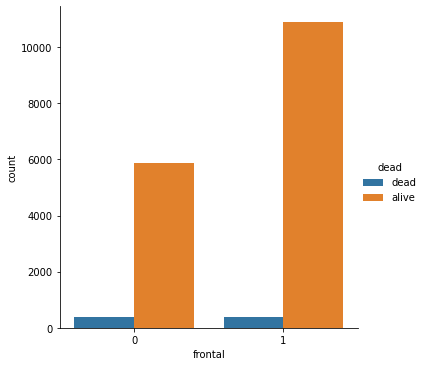

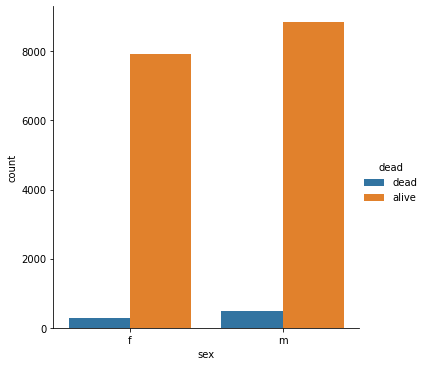

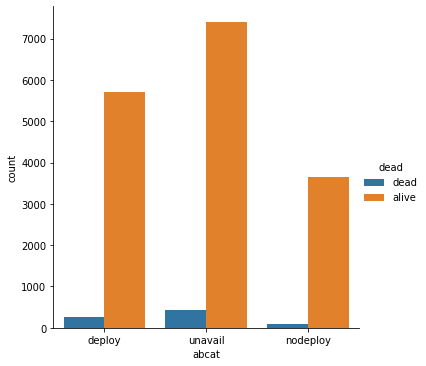

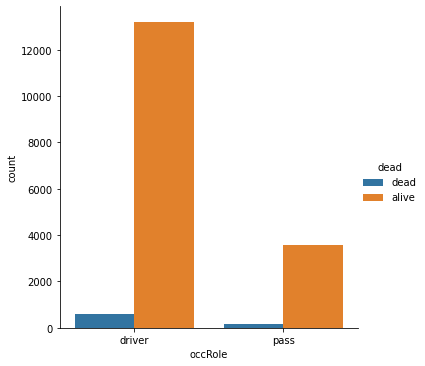

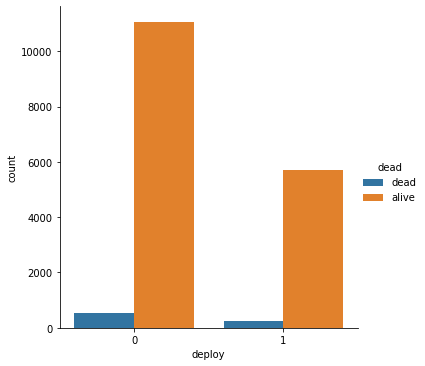

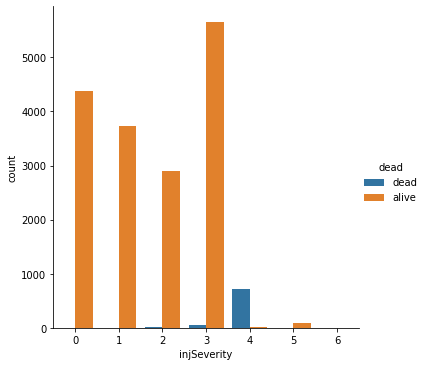

In [ ]:
#the distribution of the cathegorical variables
cat=["dvcat","airbag","seatbelt","frontal","sex","abcat","occRole","deploy","injSeverity"]
for i in cat:
    sns.catplot(x=i ,hue="dead",kind="count", data=data)


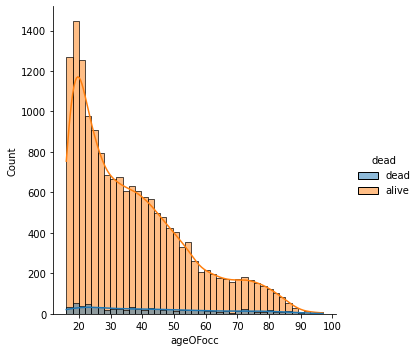

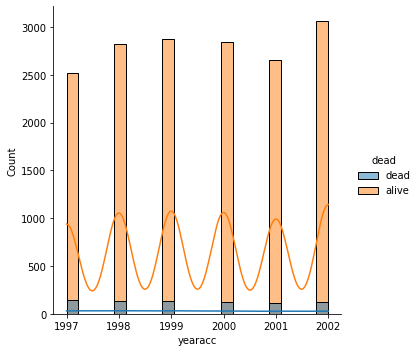

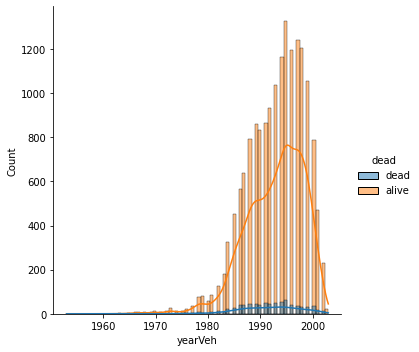

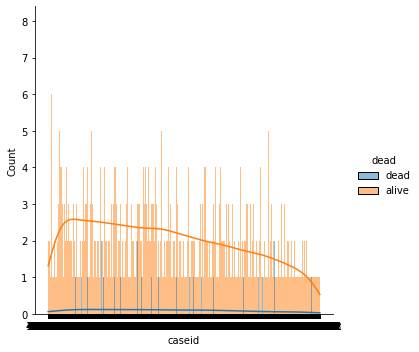

In [ ]:
#the distribution of the continuous variables
non_cat=["ageOFocc","yearacc","yearVeh","caseid"]
for i in non_cat:
  sns.displot(data, x=i,hue="dead", kde=True)

we can say that 'abcat'and 'caseid' are not important features.







In [ ]:
#The "abcat" variable
data.groupby(['abcat', 'dead'])['dead'].count()

abcat     dead 
deploy    alive    5718
          dead      257
nodeploy  alive    3659
          dead       90
unavail   alive    7411
          dead      430
Name: dead, dtype: int64

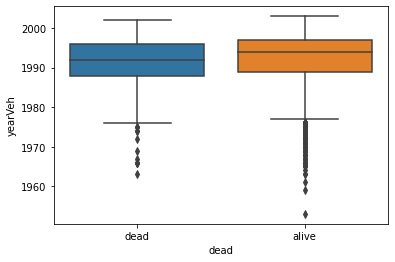

In [ ]:
#The boxplot of "yearVeh"
ax = sns.boxplot(x="dead", y="yearVeh", data=data)

We can see that this variable isn't really important.

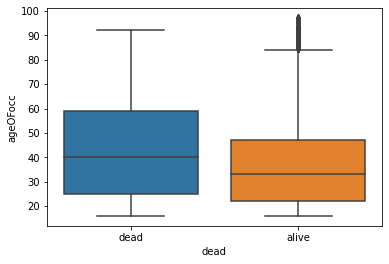

In [ ]:
ax = sns.boxplot(x="dead", y="ageOFocc", data=data)

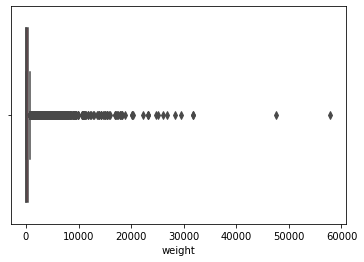

In [ ]:
#the distribution of the weight 
ax = sns.boxplot(x = data['weight'], palette = 'inferno')
ax.set_xlabel(xlabel = 'weight', fontsize = 10)
plt.show()

There are many outliears in the "weight" feature. So much noise in this variable so it'll be better not to use it.




## Preprocessing the data

In [ ]:
#changing all the values to numerical values
def processing(df):
  df.loc[df['sex'] == 'm', 'sex'] = 1
  df.loc[df['sex'] == 'f', 'sex'] = 0
  df.loc[df['dead'] == 'dead', 'dead'] = 1
  df.loc[df['dead'] == 'alive', 'dead'] = 0
  df.loc[df['dvcat'] == '1-9km/h', 'dvcat'] = 1
  df.loc[df['dvcat'] == '10-24', 'dvcat'] = 2
  df.loc[df['dvcat'] == '25-39', 'dvcat'] = 3
  df.loc[df['dvcat'] == '40-54', 'dvcat'] = 4
  df.loc[df['dvcat'] == '55+', 'dvcat'] = 5
  df.loc[df['occRole'] == 'pass', 'occRole'] = 0
  df.loc[df['occRole'] == 'driver', 'occRole'] = 1
  df.loc[df['seatbelt'] == 'none', 'seatbelt'] = 0
  df.loc[df['seatbelt'] == 'belted', 'seatbelt'] = 1
  df.loc[df['airbag'] == 'none', 'airbag'] = 0
  df.loc[df['airbag'] == 'airbag', 'airbag'] = 1
  return df
#drop the column of the less important variables  
def clean(df):
  df=df.drop(['abcat', 'caseid','weight','yearVeh'], axis=1)
  return df




In [ ]:
df=data.copy()
df=clean(df)
df=processing(df)
y=df['dead']
y=y.astype('int') 
X=df.drop(['dead'], axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=2)



# Logistic Regression model

In [ ]:
from sklearn import metrics
model=LogisticRegression()
model.fit(X_train ,y_train)
y_pred=model.predict(X_test)
y_predtrain=model.predict(X_train)
print('the accuracy of the logistic regression model is',accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


the accuracy of the logistic regression model is 0.9854824935952178
[[3356   12]
 [  39  106]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3368
           1       0.90      0.73      0.81       145

    accuracy                           0.99      3513
   macro avg       0.94      0.86      0.90      3513
weighted avg       0.98      0.99      0.98      3513



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
model1 = RandomForestClassifier(max_depth=2, random_state=0)
model1.fit(X_train, y_train)
y_pred=model1.predict(X_test)
y_predtrain=model1.predict(X_train)
print('the accuracy is',accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


the accuracy is 0.9857671505835468
[[3367    1]
 [  49   96]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3368
           1       0.99      0.66      0.79       145

    accuracy                           0.99      3513
   macro avg       0.99      0.83      0.89      3513
weighted avg       0.99      0.99      0.98      3513




The accuracy of the random forest model and the logistic regression model and the random forest model are equal. We have better precision in the random forest model but also we see a better recall in the logistic regression model.
**For the f1-score we see that the best one is in the Logistic regression model so we can say that the Logistic regression model is better.**

